# Minimización del riesgo empírico
Siguiendo el ejemplo de clasificación entre las clases NARANJA y AZUL:

1. Haga una función que genere los datos como se detalla en la presentación (modelo de mezcla de normales)
2. Genere una muestra y haga un _scatter plot_.
3. Sobre el _scatter plot_ superponga la frontera de clasificación y pinte las regiones para un clasificador basado en un ajuste:
  * lineal,
  * por el método de 25 vecinos más cercanos,
  * por el método de 1 vecinos más cercanos.
4. Realice un ajuste por el método de 25 vecinos más cercanos.
5. Genere un conjunto de test y compare el error cuadrático medio (ECM) para diferentes cantidades de vecinos. Grafique el ECM tanto para el conjunto de entrenamiento como de test todos los modelos computados.

## Inciso 1
Primero se generaron 10 medias mk a partir de una distribución
normal bivariada $N((1, 0)^{T}, \mathbb{I})$ y la etiquetamos **AZUL**.
Similarmente, otras 10 fueron generadas a partir de $N((0, 1)^{T}, \mathbb{I})$ y etiquetadas
como **NARANJA**.

In [ ]:
## Insertamos librerias que pueden ser utiles
library(class)
if(!require("ggplot2")) install.packages("ggplot2")
if(!require("mvtnorm")) install.packages("mvtnorm")
library("mvtnorm")

## Para generar los datos tomamos las medias generad

medias_azul = rmvnorm(10, mean = c(1, 0), sigma = diag(2))
medias_naranja = rmvnorm(10, mean = c(0, 1), sigma = diag(2))

medias_azul
medias_naranja

Loading required package: ggplot2

Loading required package: mvtnorm

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘mvtnorm’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



-0.07255946,1.4620027
1.16635024,-0.1186433
2.34400214,0.2495079
1.75352619,0.8358841
0.32304209,-2.2338824
0.50639354,0.8483444
0.60457958,-0.3609073
0.95015487,-0.1354703
0.20532223,0.1684618
0.37444027,1.1480096


1.22339204,0.9352445
0.40542142,1.3024712
0.07634525,2.6430107
0.63379030,1.6695295
-0.34168192,1.7792437
0.66608651,0.5469506
2.76516135,1.0849253
0.18604276,-0.5042356
1.39159551,0.5952867
-0.52690781,2.3494487


Luego, en cada clase generamos 100 observaciones a partir de una mezcla
de normales: para cada observación elegimos una media $m_{k}$ al azar
(con probabilidad 1/10), a partir de ello, el punto generado tendrá la distribución $ \mathcal{N} (m_k , \mathbb{I}/{5}).$

In [ ]:
# Generamos con esto una función para generar los datos
gen_data = function(n,medias,seed = 42){
    set.seed(seed)
    x = vector()
    y = vector()
    for (i in 1:n){
        mk = medias[sample(1:dim(medias)[1],1),]
        x = append(x,rnorm(1,mk[1],1/sqrt(5)))
        y = append(y,rnorm(1,mk[2],1/sqrt(5)))
    }
    return(cbind(x,y))
}

## Inciso 2
Para la generación de datos vamos a guardar todo en único Dataframe que nos va a permitir graficar y analizar a posterior de manera más sencilla. Además vamos a codificar los colores de la siguiente forma:

\begin{align}
  \left\{\begin{array}{lcl}
    \text{label}(\text{Azul})&=&0\\
    \text{label}(\text{Naranja})&=&1\\
  \end{array}\right.
\end{align}

In [ ]:
n.samples = 200
data = rbind(as.data.frame(cbind(rep(0,n.samples/2),
                                 gen_data(n.samples/2, medias_azul))),
             as.data.frame(cbind(rep(1,n.samples/2),
                                 gen_data(n.samples/2, medias_naranja))))

names(data) = c("label","x","y")
dim(data)

[1] 200   3

Con estos datos generados vamos a visualizar los mismos en un scatter plot

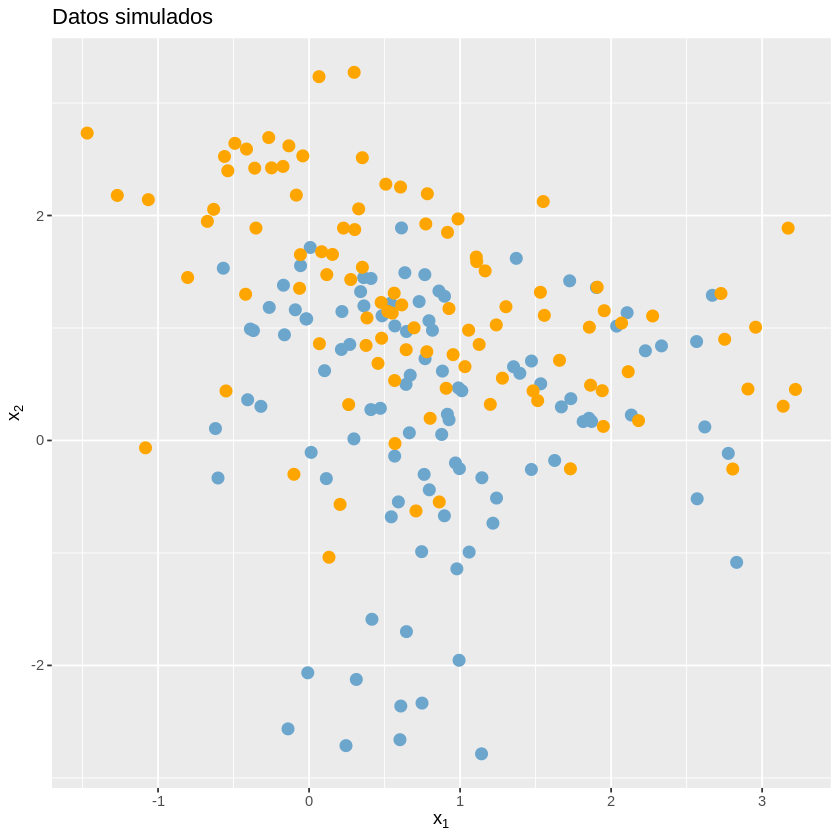

In [ ]:
f1 = ggplot(data = data) +
        geom_point(aes(x = x, y = y, colour = as.factor(label)), size = 3) +
        scale_colour_manual(values = c("skyblue3", "orange")) +
        theme(legend.position = "none")+
        labs(x=expression(x[1]),
             y=expression(x[2]),
             title='Datos simulados')
plot(f1)

## Inciso 3

### Desarrollo común a todos los ajustes

Debido a que KNN necesita de un set de testing para poder ajustar el modelo, vamos a generar una grilla de testing en nuestro espación $x_1,x_2$ que nos va a permitir determinar las regiones de decisión y además poner a prueba nuestros modelos más adelante.

In [ ]:
# grid generated based on data

## grid step
grid.step = 0.1

## boundary box of our grid
grid.range.x <- extendrange(range(data$x), f = 0.2)
grid.range.y <- extendrange(range(data$y), f = 0.2)

## borderline creation
grid.x <- seq(grid.range.x[1], grid.range.x[2], grid.step)
grid.y <- seq(grid.range.y[1], grid.range.y[2], grid.step)

## grid expansion
grilla <- expand.grid(grid.x, grid.y)

## final df
colnames(grilla) <- c("x", "y")

### Ajuste Lineal
Proponemos primero un analisis lineal multivariado de la forma:
\begin{equation}
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2
\end{equation}

In [ ]:
## ajuste lineal
ajuste = lm(data= data,formula=label~x+y)
coef_lm <- coef(ajuste)
coef_lm

(Intercept)           x           y 
 0.32899256  0.02816864  0.20347282

Dado que _lm_ nos entrega un respuesta continua para nuestro problema de clasificación vamos a generar una función auxiliar que nos permita convertir nuestra información continua en información de clase. Para ello consideramos una separación simple de regiones, dicho esto, para $\hat{y}>p$ vamos a considerar que es de la clase Naranja, mientras que será azul en otro caso.

In [ ]:
# Transformo mis predicciones a clases
f.lm.class <- function(val, threshold=0.5) ifelse(val >= threshold, 1, 0)

## con los datos de nuestro ajuste vamos a ajustar nuestros datos.
predicciones.lm <- predict(ajuste)
clases.lm.predict <- f.lm.class(predicciones.lm)

In [ ]:
# A partir de esto vamos a estimar los valores de nuestra grilla
## Ajuste de la grilla de datos generada
grid.lm.pred <- predict(ajuste, grilla)

# Utilizamos la función generada previamente para determinar la clase
grid.lm.class <- cbind(grilla, clase = f.lm.class(grid.lm.pred))

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


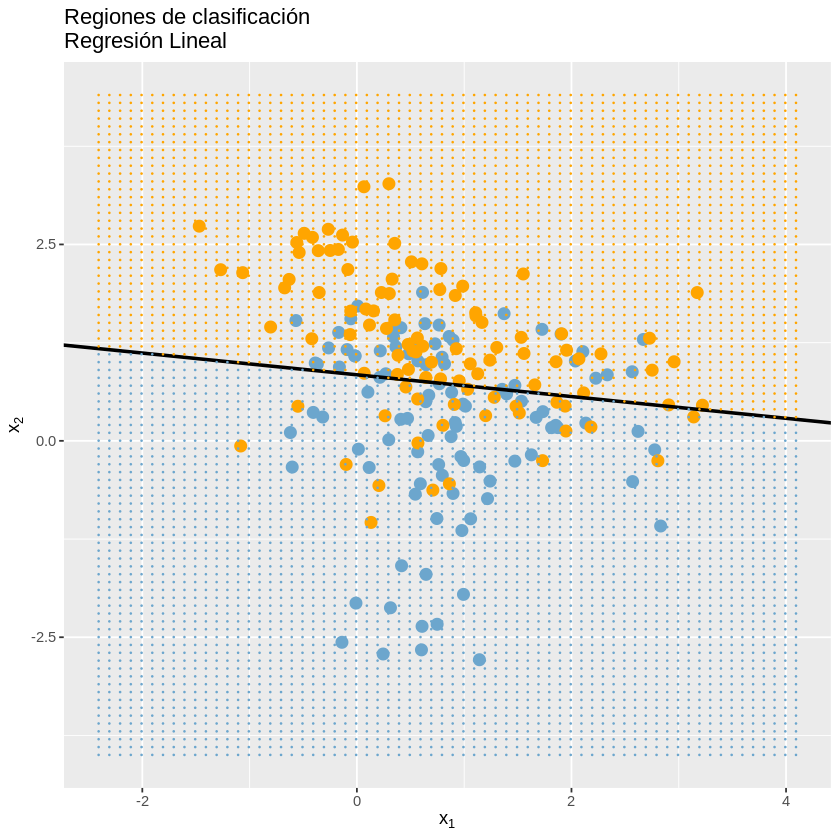

In [ ]:
# Regla de clasificación.
f2 <- f1 +
      geom_abline(intercept = (0.5 - coef_lm[1]) / coef_lm[3],
                  slope = -coef_lm[2] / coef_lm[3],
                  size = 1, colour = "black") +
      geom_point(data = grid.lm.class,
               aes(x = x, y = y, colour = as.factor(clase)), size = 0.1)+
      theme(legend.position = "none") +
      labs(x=expression(x[1]),
       y=expression(x[2]),
       title='Regiones de clasificación\nRegresión Lineal')
f2

### Vecinos cercanos con k = 25

In [ ]:
# Ajustamos utilizando un k=25
model.knn.25 <- knn(train = data[, -1],test = grilla, cl = data$label,
                         k = 25)


## Vamos a generar los datos de grilla para poder graficar los mismos
grilla.pred.knn.k25 <- cbind(grilla, label = as.numeric(model.knn.25)-1)

## Generamos el contorno de la región de decisión
grilla.contour.k25 <- data.frame(x = grilla[, 1], y = grilla[, 2],
                             z = as.numeric(model.knn.25)-1)

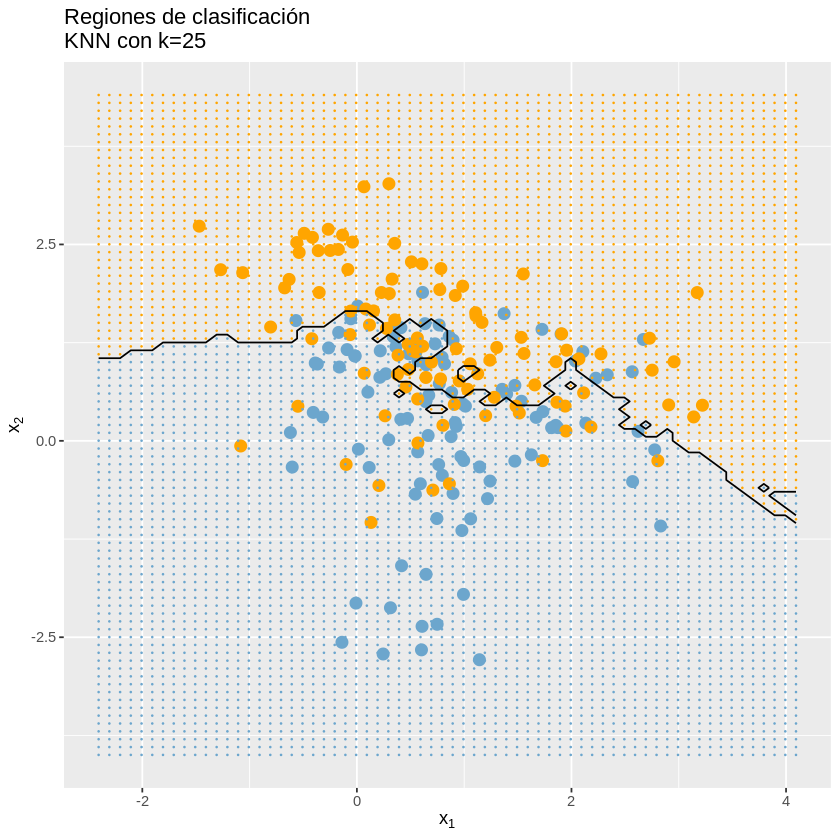

In [ ]:
f3 = f1 +
    geom_point(data = grilla.pred.knn.k25,
               aes(x = x, y = y, colour = as.factor(label)), size = 0.1) +
    geom_contour(data = grilla.contour.k25,
                 aes(x = x, y = y, z = z), breaks = c(0, 0.5), col = "black") +
    theme(legend.position = "none")+
    labs(title='Regiones de clasificación\nKNN con k=25')
f3

### Vecinos cercanos con k = 1

In [ ]:
# Ajustamos utilizando un k=1
model.knn.k1 <- knn(train = data[, -1],test = grilla, cl = data$label,
                         k = 1)

## Vamos a generar los datos de grilla para poder graficar los mismos
grilla.pred.knn.k1 <- cbind(grilla, label = as.numeric(model.knn.k1)-1)

## Generamos el contorno de la región de decisión
grilla.contour.k1 <- data.frame(x = grilla[, 1], y = grilla[, 2],
                             z = as.numeric(model.knn.k1)-1)

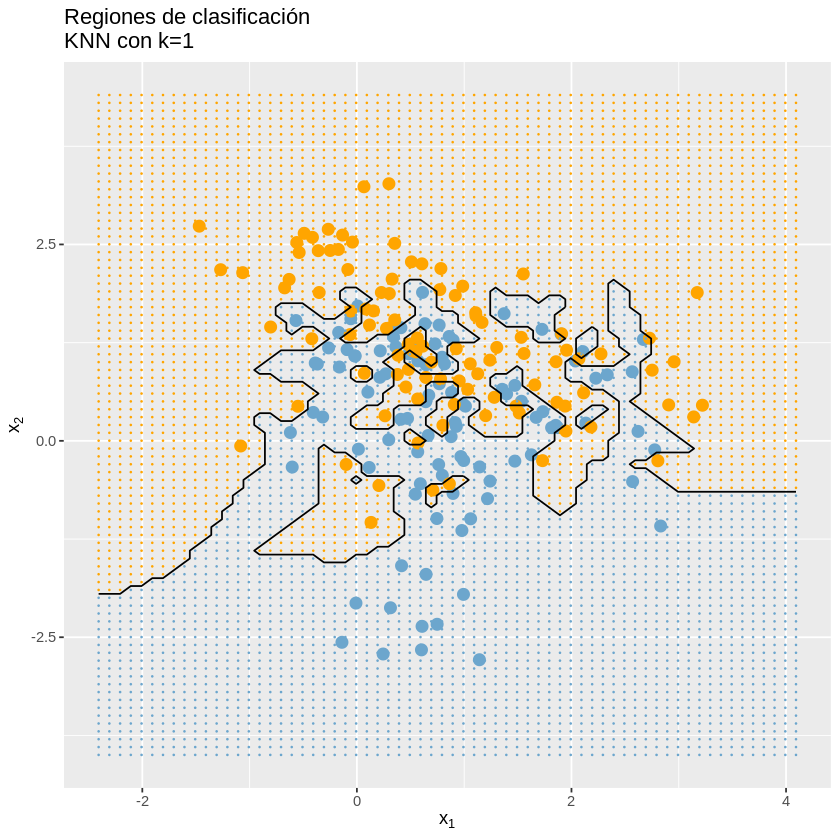

In [ ]:
f4 = f1 +
    geom_point(data = grilla.pred.knn.k1,
               aes(x = x, y = y, colour = as.factor(label)), size = 0.1) +
    geom_contour(data = grilla.contour.k1,
                 aes(x = x, y = y, z = z), breaks = c(0, 0.5), col = "black") +
    theme(legend.position = "none")+
    labs(title='Regiones de clasificación\nKNN con k=1')
f4

## Inciso 4

In [ ]:
model.knn.25

[1] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  [38] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  [75] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [112] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [149] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [186] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [223] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [260] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [297] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [334] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [371] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [408] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [445] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [482] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [519] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [556] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [593] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [630] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [667] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [704] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [741] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [778] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [815] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [852] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [889] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [926] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [963] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1000] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1037] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1074] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1111] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1148] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1185] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1222] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1259] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1296] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1333] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1370] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1407] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1444] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1481] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1518] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1555] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1592] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1629] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1666] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1703] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1740] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1777] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1814] 0 0 0 0 0 0 0 0 0 0 0 0 0 0

## Inciso 5

### Generación de datos para la simulación

Para este caso vamos a generar una simulación con 10000 datos generados (5000 de cada clase) de manera similar al caso considerado previamente utilizando la función _gen_data_

In [ ]:
# Generamos las observaciones el conjunto de test
n.test = 5e3

test.data.blue = gen_data(medias = medias_azul, n = n.test, seed = 57)
test.data.orange = gen_data(medias = medias_naranja, n = n.test, seed = 57)

test.data = rbind(as.data.frame(cbind(rep(0,n.test/2),
                                 test.data.blue)),
             as.data.frame(cbind(rep(1,n.test/2),
                                 test.data.orange)))

names(test.data) = c("label","x","y")
dim(test.data)

[1] 10000     3

Generamos además una función que nos permita probar multiples valores de _k_ para el algoritmo de KNN.

In [ ]:
knn.test = function(k){
  ## Prediction on train set
  pred_train = knn(train = data[, -1],
                   test = data[, -1],
                   cl = data$label,
                   k = k)
  ## Prediction on test set
  pred_test = knn(train = data[, -1],
                  test = test.data[,-1],
                  cl = data$label,
                  k = k)

  ## error of train set
  train = mean((as.numeric(pred_train)-1) != data$label)
  ## error of test set
  test = mean((as.numeric(pred_test)-1) != test.data$label)

  return(list(train,test))
}

### Testeos de los datos

In [ ]:
## Generamos una lista de k's validos para knn
k.vals = c(1,3,seq(5,150,by = 5))

## realizamos las pruebas
k.tests = sapply(k.vals,knn.test)

## Guardamos la información en un dataframe
k.testings = data.frame(k.eff = n.samples/k.vals,
                        train = unlist(k.tests[1, ]),
                        test = unlist(k.tests[2, ]))
head(k.testings)

,k.eff,train,test
,<dbl>,<dbl>,<dbl>
1,200.00000,0.000,0.3650
2,66.66667,0.210,0.3281
3,40.00000,0.225,0.3211
4,20.00000,0.275,0.3194
5,13.33333,0.270,0.3143
6,10.00000,0.325,0.3080


In [ ]:
## Ahora hacemos el mismo análisis pero para nuestro regresor lineal multivariado.
## dado que en el mismo solo tenemos 1 regresor, vamos a tener 1 punto de train
## y 1 punto de test

lm.train.pred = f.lm.class(predict(ajuste))
lm.train.error = mean(lm.train.pred != data$label)

lm.test.pred = f.lm.class(predict(ajuste, test.data))
lm.test.error = mean(lm.test.pred != test.data$label)

lm.train.error
lm.test.error

[1] 0.325

[1] 0.3004

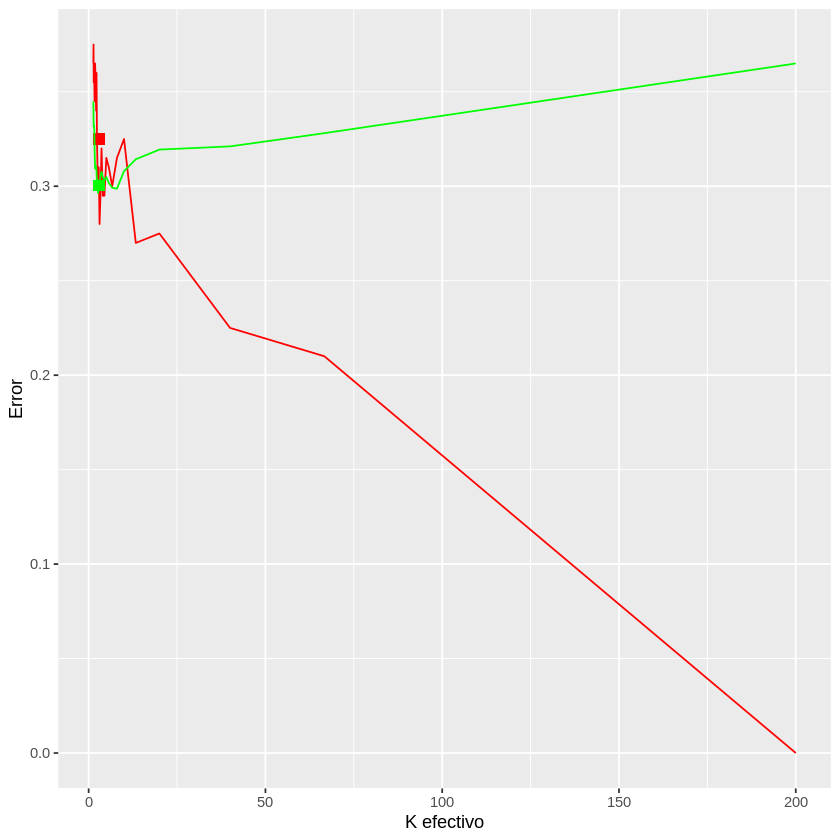

In [ ]:
f5 = ggplot(k.testings) +
    geom_line(aes(x = k.eff, y = train), col = "red") +
    geom_point(aes(x = 3, y = lm.train.error),
               size = 3, shape = 15, col = "red") +
    geom_point(aes(x = 3, y = lm.test.error),
               size = 3, shape = 15, col = "green") +
    geom_line(aes(x = k.eff, y = test), colour = "green") +
    ylab("Error") +
    xlab("K efectivo") +
    #scale_x_continuous(trans='log10') +
    theme(legend.position = "left")
f5

--------------------

In [ ]:
# Pseudo code:

# Step 1: Estimate parameters
mu_azul = colMeans(data[data$label==0, c('x', 'y')])
sigma_azul = cov(data[data$label==0, c('x', 'y')])

mu_naranja = colMeans(data[data$label==1, c('x', 'y')])
sigma_naranja = cov(data[data$label==1, c('x', 'y')])

# Step 2: Create a grid spanning the range of 'x' and 'y' values in your data
grid = expand.grid(x = seq(min(data$x), max(data$x), length.out=100),
                   y = seq(min(data$y), max(data$y), length.out=100))

# Step 3: Compute probabilities for each point in the grid
p_azul = dmvnorm(grid, mean = mu_azul, sigma = sigma_azul)
p_naranja = dmvnorm(grid, mean = mu_naranja, sigma = sigma_naranja)

# Step 4: Compute the Bayes error
bayes_error = sum(ifelse(p_azul > p_naranja, p_naranja, p_azul))


In [ ]:
bayes_error

[1] 197.1929